## Imports

In [1]:
import scipy.io
import scipy.signal

import os 
import pandas as pd
import zipfile
import requests
import xlrd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import statistics as stats
from math import isclose
from sklearn import mixture

%matplotlib inline

## Nicole's imports

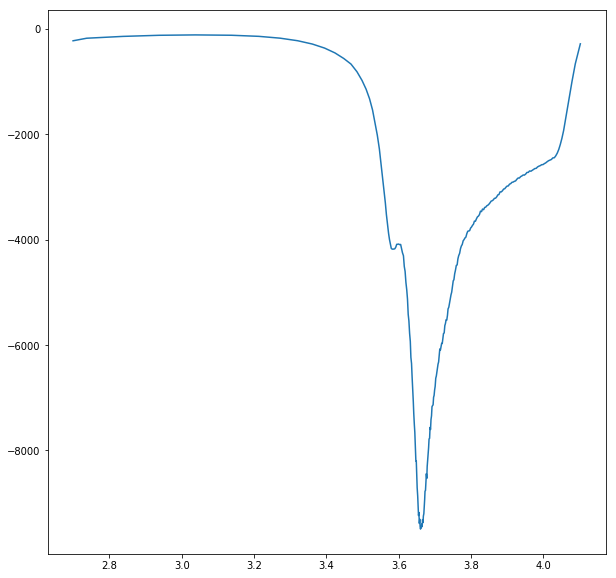

In [74]:
import chachifuncs

#chachifuncs.load_sep_cycles('NLT_Test/NLT_TestSource/', 'NLT_Test/NLT_TestSepCycles/')
# I had to make this first directory (source) just as a small set of the data to test this code on, and then had to make a 
#directory for where I wanted my cycles to be stored in once they were seperated out. This code takes a while to run.

testdf = pd.read_excel('NLT_Test/NLT_TestSource/NLTtestCycle10.xlsx')
#just picked a random one out of the separated out cycles

charge, discharge = chachifuncs.clean_calc_sep_smooth(testdf, 25, 3)

fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(charge['Voltage(V)'], charge['Smoothed_dQ/dV'])

{'coefficients': [5424202.203703533,
  -6092146.488284593,
  2534469.8195974543,
  -463065.89072995295],
 'peakFWHM': [0.12180528097506027, 0.03566528717831918, 0.005939236837501971],
 'peakHeight(dQdV)': array([2577.68513441, 9464.55003739, 4164.44766827]),
 'peakLocation(V)': array([3.99498367, 3.66257691, 3.57931328])}

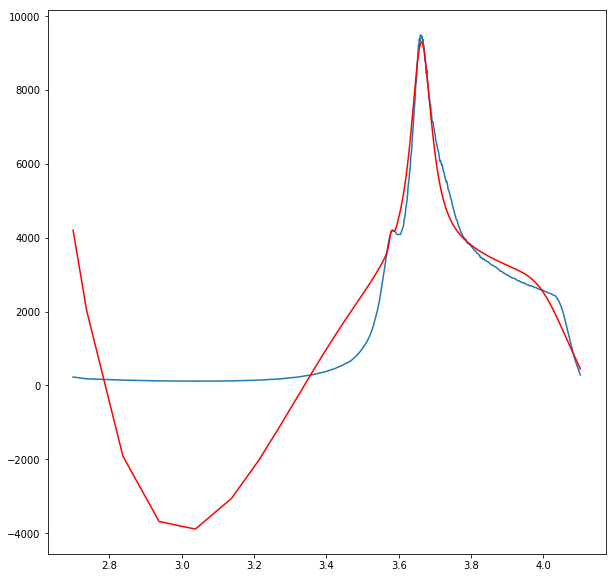

In [75]:
descriptor_func(charge['Voltage(V)'], charge['Smoothed_dQ/dV'], 'c')

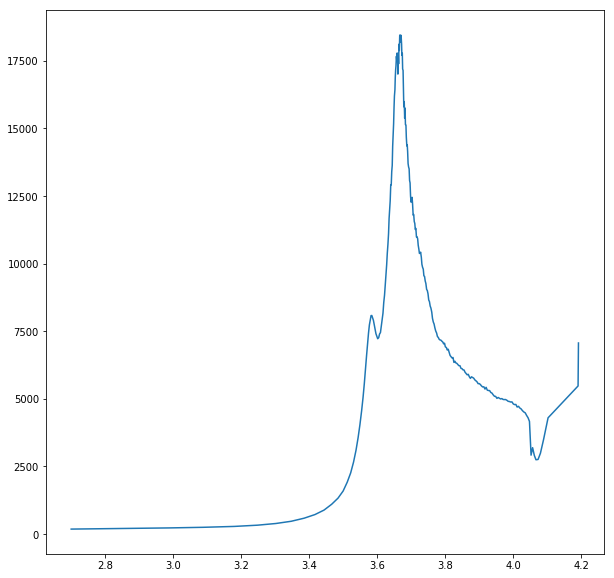

In [4]:
sigx_bot = pd.to_numeric(charge['Voltage(V)']).as_matrix()
sigy_bot = -pd.to_numeric(charge['Smoothed_dQ/dV']).as_matrix()

fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(sigx_bot, sigy_bot)

## Peak Utils Peak finder

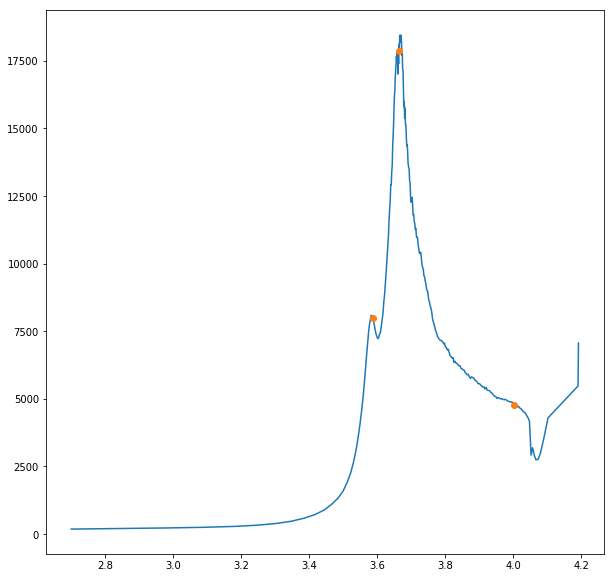

In [13]:
pwid = 3
sigy_smooth = scipy.signal.savgol_filter(sigy_bot, 25, 3)
import peakutils
i = peakutils.indexes(sigy_smooth, thres=3/max(sigy_bot), min_dist=9)
#i = scipy.signal.find_peaks_cwt(sigy, sigx*9)

fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
plt.plot(sigx_bot, sigy_bot)
plt.plot(sigx_bot[i], sigy_bot[i], 'o')

Function Version

In [27]:
import peakutils
import scipy.signal

def peak_finder(V_series, dQdV_series, cd):    
    sigx, sigy = cd_dataframe(V_series, dQdV_series, cd)
    
    sigy_smooth = scipy.signal.savgol_filter(sigy_bot, 25, 3)
        
    i = peakutils.indexes(sigy_smooth, thres=3/max(sigy_smooth), min_dist=9)
    return i

def cd_dataframe(V_series, dQdV_series, cd):
    
    sigx = pd.to_numeric(V_series).as_matrix()
    if cd == 'c':      
        sigy = -pd.to_numeric(dQdV_series).as_matrix()
    elif cd == 'd':
        sigy = pd.to_numeric(dQdV_series).as_matrix()
    
    return sigx, sigy
    

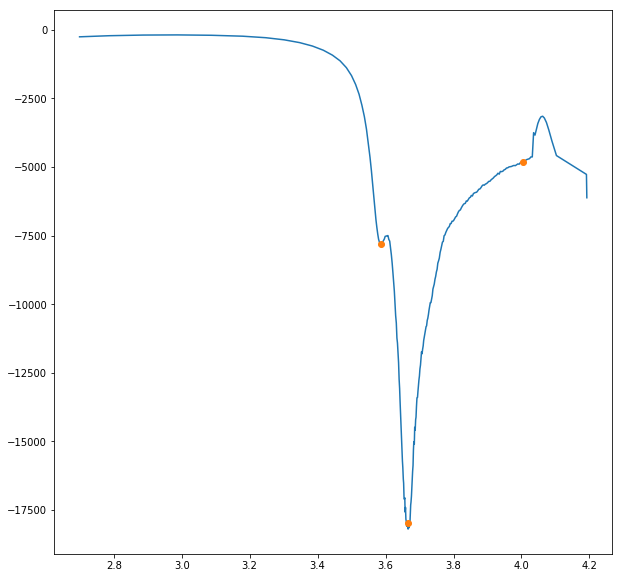

In [28]:
i = peak_finder(charge['Voltage(V)'], charge['Smoothed_dQ/dV'], 'c')

fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(charge['Voltage(V)'], charge['Smoothed_dQ/dV'])
myplot = plt.plot(charge.loc[i, 'Voltage(V)'], charge.loc[i, 'Smoothed_dQ/dV'], 'o')

## LMfit code

In [93]:
from lmfit import models

mod = models.PolynomialModel(4)
par = mod.guess(sigy_bot, x=sigx_bot)
#i = np.append(i, i+5)
print(i)


for index in i:
    pref = str(int(index))
    comb = 'a' + pref + '_'
    
    gaus_loop = models.PseudoVoigtModel(prefix=comb)
    par.update(gaus_loop.make_params())
    cent = 'center'
    sig = 'sigma'
    amp = 'amplitude'
    fract = 'fraction'
    
    par[comb+cent].set(sigx_bot[index], vary=False)
    par[comb+sig].set(0.001)
    par[comb+amp].set(5, min=0)
    par[comb+fract].set(.5)

    mod = mod + gaus_loop

[141 165 194]


## LMfit function

In [73]:
from lmfit import models

def model_gen(V_series, dQdV_series, cd, i):
    sigx_bot, sigy_bot = cd_dataframe(V_series, dQdV_series, cd)
    
    mod = models.PolynomialModel(4)
    par = mod.guess(sigy_bot, x=sigx_bot)
    #i = np.append(i, i+5)
    #print(i)

    for index in i:
        
        center, sigma, amplitude, fraction, comb = label_gen(index)
        
        gaus_loop = models.PseudoVoigtModel(prefix=comb)
        par.update(gaus_loop.make_params())

        par[center].set(sigx_bot[index], vary=False)
        par[sigma].set(0.001)
        par[amplitude].set(5, min=0)
        par[fraction].set(.5, min=0, max=1)

        mod = mod + gaus_loop
        
    return par, mod

def model_eval(V_series, dQdV_series, cd, par, mod):
    sigx_bot, sigy_bot = cd_dataframe(V_series, dQdV_series, cd)
    
    model = mod.fit(sigy_bot, par, x=sigx_bot)
    #print(model.fit_report(min_correl=0.5))

    fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
    plt.plot(sigx_bot, sigy_bot)
    #plt.plot(sigx_bot, model.init_fit, 'k--')
    plt.plot(sigx_bot, model.best_fit, 'r-')
    
    return model

def label_gen(index):
    
    pref = str(int(index))
    comb = 'a' + pref + '_'
    
    cent = 'center'
    sig = 'sigma'
    amp = 'amplitude'
    fract = 'fraction'
    
    center = comb + cent
    sigma = comb + sig
    amplitude = comb + amp
    fraction = comb + fract
    
    return center, sigma, amplitude, fraction, comb
    

[ 21 160 205]
[[Model]]
    (((Model(polynomial) + Model(pvoigt, prefix='a21_')) + Model(pvoigt, prefix='a160_')) + Model(pvoigt, prefix='a205_'))
[[Fit Statistics]]
    # function evals   = 20606
    # data points      = 238
    # variables        = 14
    chi-square         = 505317050.683
    reduced chi-square = 2255879.691
    Akaike info crit   = 3495.285
    Bayesian info crit = 3543.897
[[Variables]]
    c0:               1.5145e+07 +/- 0        (0.00%) (init= 1.509032e+07)
    c1:              -1.7346e+07 +/- 0        (0.00%) (init=-1.733631e+07)
    c2:               7.3845e+06 +/- 0        (0.00%) (init= 7388906)
    c3:              -1.3857e+06 +/- 0        (0.00%) (init=-1385266)
    c4:               96784.7023 +/- 0        (0.00%) (init= 96460.89)
    a21_fraction:     1          +/- 0        (0.00%) (init= 0.5)
    a21_sigma:        0.26181188 +/- 0        (0.00%) (init= 0.001)
    a21_center:       4.004055 (fixed)
    a21_amplitude:    1864.94461 +/- 0        (0.00%) 

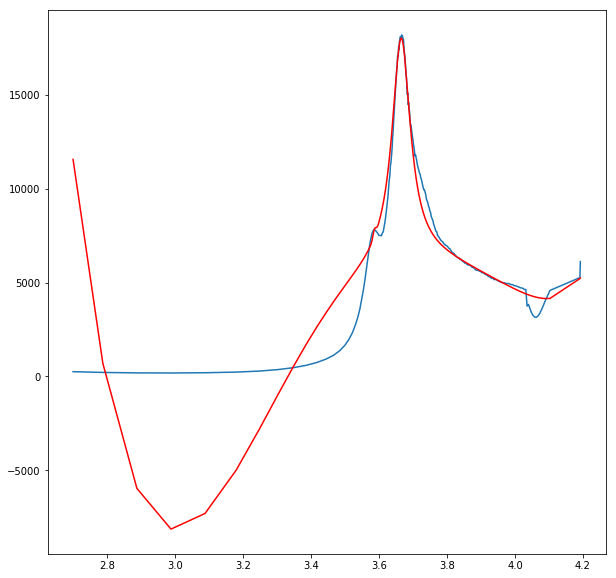

In [57]:
par, mod = model_gen(charge['Voltage(V)'], charge['Smoothed_dQ/dV'], 'c', i)

model = model_eval(charge['Voltage(V)'], charge['Smoothed_dQ/dV'], 'c', par, mod)

In [41]:
model.best_values

{'a160_amplitude': 1204.5866768625697,
 'a160_center': 3.665168762207031,
 'a160_fraction': 0.9999395740501419,
 'a160_sigma': 0.03271931592717259,
 'a205_amplitude': 4.396018661100393,
 'a205_center': 3.586440801620483,
 'a205_fraction': 1.0103029524088925e-13,
 'a205_sigma': 0.005223141124625519,
 'a21_amplitude': 1864.944618803519,
 'a21_center': 4.004055023193359,
 'a21_fraction': 0.999999999999958,
 'a21_sigma': 0.2618118855452114,
 'c0': 15144956.27369092,
 'c1': -17346234.574764214,
 'c2': 7384508.879733742,
 'c3': -1385730.6474814473,
 'c4': 96784.70232873314}

## Putting it all together

In [71]:
def descriptor_func(V_series,dQdV_series, cd):
    sigx_bot, sigy_bot = cd_dataframe(V_series, dQdV_series, cd)
    
    i = peak_finder(V_series,dQdV_series, cd)
    
    par, mod = model_gen(V_series,dQdV_series, cd, i)

    model = model_eval(V_series,dQdV_series, cd, par, mod)
    
    sigx, sigy = cd_dataframe(V_series, dQdV_series, cd) 
    
    desc = {'peakLocation(V)': sigx[i], 'peakHeight(dQdV)': sigy[i]}
    
    FWHM = []
    for index in i:
        center, sigma, amplitude, fraction, comb = label_gen(index)
        FWHM.append(model.best_values[sigma])

    
    coefficients = []
    for k in np.arange(4):
        coef = 'c' + str(k)
        coefficients.append(model.best_values[coef])
        
    desc.update({'peakFWHM': FWHM, 'coefficients': coefficients})
    
    return desc
    
    

[ 21 160 205]
[[Model]]
    (((Model(polynomial) + Model(pvoigt, prefix='a21_')) + Model(pvoigt, prefix='a160_')) + Model(pvoigt, prefix='a205_'))
[[Fit Statistics]]
    # function evals   = 20606
    # data points      = 238
    # variables        = 14
    chi-square         = 505317050.683
    reduced chi-square = 2255879.691
    Akaike info crit   = 3495.285
    Bayesian info crit = 3543.897
[[Variables]]
    c0:               1.5145e+07 +/- 0        (0.00%) (init= 1.509032e+07)
    c1:              -1.7346e+07 +/- 0        (0.00%) (init=-1.733631e+07)
    c2:               7.3845e+06 +/- 0        (0.00%) (init= 7388906)
    c3:              -1.3857e+06 +/- 0        (0.00%) (init=-1385266)
    c4:               96784.7023 +/- 0        (0.00%) (init= 96460.89)
    a21_fraction:     1          +/- 0        (0.00%) (init= 0.5)
    a21_sigma:        0.26181188 +/- 0        (0.00%) (init= 0.001)
    a21_center:       4.004055 (fixed)
    a21_amplitude:    1864.94461 +/- 0        (0.00%) 

{'coefficients': [15144956.27369092,
  -17346234.574764214,
  7384508.879733742,
  -1385730.6474814473],
 'peakFWHM': [0.2618118855452114, 0.03271931592717259, 0.005223141124625519],
 'peakHeight(dQdV)': array([ 4818.08876597, 17977.98977003,  7819.18324064]),
 'peakLocation(V)': array([4.00405502, 3.66516876, 3.5864408 ])}

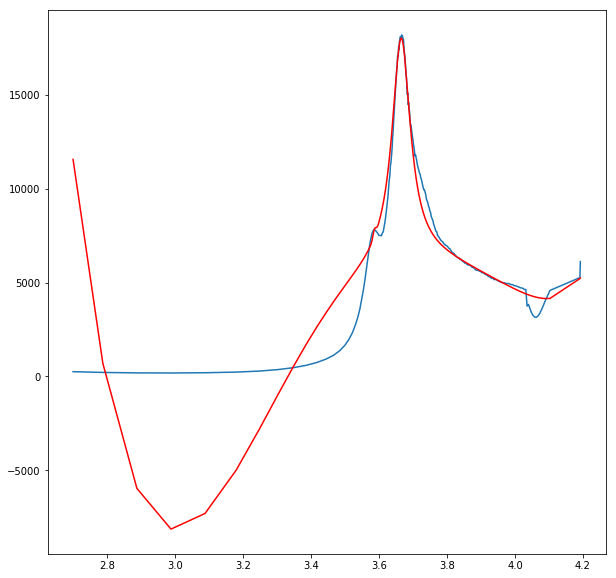

In [72]:
descriptor_func(charge['Voltage(V)'], charge['Smoothed_dQ/dV'], 'c')

In [70]:
i2 = np.array([i[-1] + 10])
for index in i2:
    pref = str(int(index))
    comb = 'a' + pref + '_'
    
    gaus_loop = models.GaussianModel(prefix=comb)
    par.update(gaus_loop.make_params())
    cent = 'center'
    sig = 'sigma'
    amp = 'amplitude'
    
    par[comb+cent].set(sigx_bot[index])
    par[comb+sig].set(0.01)
    par[comb+amp].set(500)

    mod = mod + gaus_loop

[[Model]]
    (((Model(polynomial) + Model(pvoigt, prefix='a141_')) + Model(pvoigt, prefix='a165_')) + Model(pvoigt, prefix='a194_'))
[[Fit Statistics]]
    # function evals   = 912
    # data points      = 219
    # variables        = 14
    chi-square         = 57124621.617
    reduced chi-square = 278656.691
    Akaike info crit   = 2759.297
    Bayesian info crit = 2806.744
[[Variables]]
    c0:               7.0671e+06 +/- 3.05e+06 (43.17%) (init= 9.36364e+07)
    c1:              -7.1961e+06 +/- 3.39e+06 (47.07%) (init=-1.036788e+08)
    c2:               2.6989e+06 +/- 1.41e+06 (52.09%) (init= 4.28745e+07)
    c3:              -4.4052e+05 +/- 2.59e+05 (58.70%) (init=-7848876)
    c4:               26297.9142 +/- 1.78e+04 (67.62%) (init= 536789.2)
    a141_fraction:    1.91882253 +/- 0.021405 (1.12%) (init= 0.5)
    a141_sigma:       0.02093164 +/- 0.000494 (2.36%) (init= 0.001)
    a141_center:      3.685742 (fixed)
    a141_amplitude:   1245.73199 +/- 49.61403 (3.98%) (init= 5)

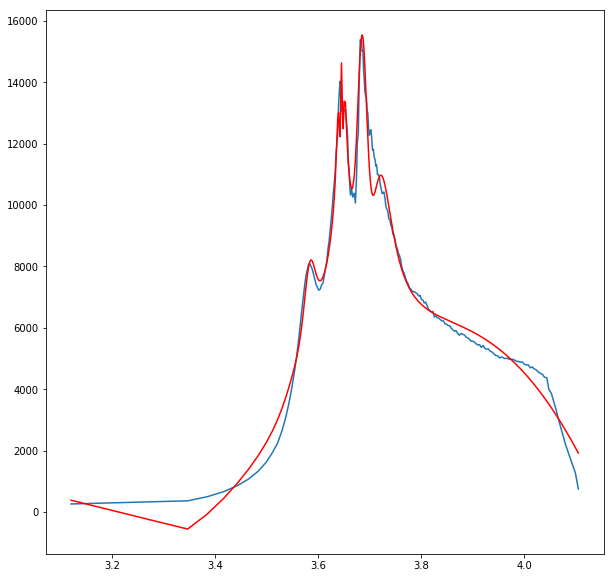

In [94]:
model = mod.fit(sigy_bot, par, x=sigx_bot)
print(model.fit_report(min_correl=0.5))

fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
plt.plot(sigx_bot, sigy_bot)
#plt.plot(sigx_bot, model.init_fit, 'k--')
plt.plot(sigx_bot, model.best_fit, 'r-')